In [1]:
import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)

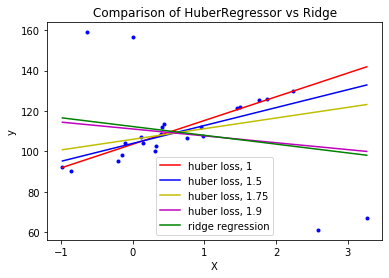

In [2]:
# Authors: Manoj Kumar mks542@nyu.edu
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_regression
from sklearn.linear_model import HuberRegressor, Ridge

# Generate toy data.
rng = np.random.RandomState(0)
X, y = make_regression(
    n_samples=20, n_features=1, random_state=0, noise=4.0, bias=100.0
)

# Add four strong outliers to the dataset.
X_outliers = rng.normal(0, 0.5, size=(4, 1))
y_outliers = rng.normal(0, 2.0, size=4)
X_outliers[:2, :] += X.max() + X.mean() / 4.0
X_outliers[2:, :] += X.min() - X.mean() / 4.0
y_outliers[:2] += y.min() - y.mean() / 4.0
y_outliers[2:] += y.max() + y.mean() / 4.0
X = np.vstack((X, X_outliers))
y = np.concatenate((y, y_outliers))
plt.plot(X, y, "b.")

# Fit the huber regressor over a series of epsilon values.
colors = ["r-", "b-", "y-", "m-"]

x = np.linspace(X.min(), X.max(), 7)
epsilon_values = [1, 1.5, 1.75, 1.9]
for k, epsilon in enumerate(epsilon_values):
    huber = HuberRegressor(alpha=0.0, epsilon=epsilon)
    huber.fit(X, y)
    coef_ = huber.coef_ * x + huber.intercept_
    plt.plot(x, coef_, colors[k], label="huber loss, %s" % epsilon)

# Fit a ridge regressor to compare it to huber regressor.
ridge = Ridge(alpha=0.0, random_state=0)
ridge.fit(X, y)
coef_ridge = ridge.coef_
coef_ = ridge.coef_ * x + ridge.intercept_
plt.plot(x, coef_, "g-", label="ridge regression")

plt.title("Comparison of HuberRegressor vs Ridge")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(loc=0)
plt.show()

In [3]:
huber.coef_ 

array([-3.40390959])

In [4]:
import pandas as pd

In [5]:
pd.Series(huber.coef_)

0   -3.40391
dtype: float64

In [6]:
# fit_intercept = False <- no need for intercept in deconvolution


In [48]:
def compute_deconvolution_huber(score_df_path, score_type, atlas, epsilon, match=True, force_zero=False):
    '''
    Run nonnegative least squares ||Ax-b||_2. 
    The solution x is the deconvolution of b.
    
    Reasoning for match=True:
    Note that for lower total read count for a mixture, there be regions that
    are missing in score_df. At 1M reads, this not a problem.
    
    score_df -- methylation score dataframe
    score_type -- hypo or hyper score: e.g. 'frac_alpha_leq_25pct'
    atlas -- atlas dataframe
    '''
    # load score df
    score_df = pd.read_csv(score_df_path, sep='\t')
    score_df.index = score_df.region_id
    
    # subset score_df regions to atlas regions
    score_df = score_df[score_df.region_id.isin(atlas.index)]
    
    b = score_df[score_type]
    A = atlas
    
    # match index between A and b
    if match:
        region_count_before = A.shape[0]
        A = A[A.index.isin(b.index)]
        region_count_after = A.shape[0]
        region_count_diff = region_count_before - region_count_after 
        print(f'Dropped: {region_count_diff} regions.')
    
    # sort the indices for A to match b indices
    A_sorted = A.loc[b.index, :]
    
    # alpha = 0 no regularization
    huber = HuberRegressor(alpha=0.0, 
                           epsilon=epsilon, 
                           fit_intercept = False)
    huber.fit(A_sorted, b)
    
    # run huber
    x = pd.Series(huber.coef_, index=A_sorted.columns) 
    
    # if force_zero is set to True then set negative to 0
    if force_zero:
        x[x < 0] = 0
    
    return(x)


def compute_deconvolution_n_times_huber(mixture_replicates_path, score_type, atlas, epsilon, match=True, force_zero=False):
    '''
    
    mixture_replicates_path -- path to a mixture (proportion) directory of replicates (e.g. ../E1B_E18CD4_E18CD8_E18NK_E18MONO_E18NEUTRO/)
    output: pandas df
    
    '''
    # given path to mixture grab all paths to mixture replicates
    list_mixture_dir_paths = get_file_paths(mixture_replicates_path)
    
    # run deconvolution for each replicate
    results = []
    samples_name = []
    for path in list_mixture_dir_paths:
        deconv = compute_deconvolution_huber(score_df_path=path, 
                                           atlas=atlas, 
                                           score_type=score_type, 
                                           match=match,
                                           force_zero=force_zero)
        results.append(deconv)
    df = pd.concat(results, axis=1)
    
    return df 


def compute_deconvolution_from_methyl_score_dir_huber(path_to_methyl_score_dir, score_type, atlas, epsilon, match=True, force_zero=False):
    '''
    '''
    # grab all file paths in methyl_score directory
    list_methyl_score_dir = get_file_paths(path_to_methyl_score_dir)
    
    # run deconvolution on each mixture proportion
    results = []
    for path in list_methyl_score_dir:
        df = compute_deconvolution_n_times_huber(mixture_replicates_path=path, 
                                               score_type=score_type, 
                                               atlas=atlas, 
                                               epsilon=epsilon,
                                               match=match,
                                               force_zero=force_zero)
        results.append(df)
    
    return(results)


In [49]:
# def compute_deconvolution_huber(score_df_path, score_type, atlas, epsilon, match=True):
#     '''
#     Run nonnegative least squares ||Ax-b||_2. 
#     The solution x is the deconvolution of b.
    
#     Reasoning for match=True:
#     Note that for lower total read count for a mixture, there be regions that
#     are missing in score_df. At 1M reads, this not a problem.
    
#     score_df -- methylation score dataframe
#     score_type -- hypo or hyper score: e.g. 'frac_alpha_leq_25pct'
#     atlas -- atlas dataframe
#     '''
#     # load score df
#     score_df = pd.read_csv(score_df_path, sep='\t')
#     score_df.index = score_df.region_id
    
#     # subset score_df regions to atlas regions
#     score_df = score_df[score_df.region_id.isin(atlas.index)]
    
#     b = score_df[score_type]
#     A = atlas
    
#     # match index between A and b
#     if match:
#         region_count_before = A.shape[0]
#         A = A[A.index.isin(b.index)]
#         region_count_after = A.shape[0]
#         region_count_diff = region_count_before - region_count_after 
#         print(f'Dropped: {region_count_diff} regions.')
    
#     # sort the indices for A to match b indices
#     A_sorted = A.loc[b.index, :]
    
#     # alpha = 0 no regularization
#     huber = HuberRegressor(alpha=0.0, 
#                            epsilon=epsilon, 
#                            fit_intercept = False)
#     huber.fit(A_sorted, b)
    
#     # run huber
#     x = pd.Series(huber.coef_, index=A_sorted.columns) 
#     # pd.Series(fit[0], index=A_sorted.columns)
    
#     return(x)



In [253]:
ROOT_DIR = '/analysis/gh-msun/'
PROJECT_SLUG = '2023_06_26_SRT_deconvolution_MS'

#---Local paths---#
PROJECT_DIR = ROOT_DIR + f'projects/{PROJECT_SLUG}/'

# Reference matrix
ATLAS_PATH = PROJECT_DIR + 'output/reference/deconv_inhouse_v2.atlas.tsv.gz'
REGION_PATH = PROJECT_DIR + 'output/reference/deconv_inhouse_v2.region_to_ref_celltype.tsv.gz'

atlas = pd.read_csv(ATLAS_PATH, sep='\t',index_col=None)
atlas = atlas.set_index('region_id')
atlas.columns.name = 'ref_celltype'
atlas.shape

ref_region_df = pd.read_csv(REGION_PATH, sep='\t')

atlas = atlas.loc[ref_region_df['region_id'], :].copy()

In [254]:
score_df_path = '/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/output/experiment/primary_immune/Blueprint-B-wholeblood/methyl_score/E06B_E16CD4_E07CD8_E05NK_E09MONO_E57NEUTRO/mix10_seed928973.tsv.gz'
score_type = 'frac_alpha_leq_25pct'
epsilon = 1

compute_deconvolution_huber(score_df_path=score_df_path, score_type=score_type, atlas=atlas, epsilon=5, match=True, force_zero=False)

Dropped: 0 regions.


ref_celltype
immune_b                            0.061178
immune_t                            0.220075
immune_nk                           0.044837
immune_dend_plus_macro_plus_mono    0.100299
immune_eosi                         0.001019
immune_neutro                       0.563015
immune_eryth                        0.002031
immune_mega                         0.003478
eryth_prog                         -0.003375
dtype: float64

In [248]:
atlas['eryth_prog'] = 1

In [249]:
compute_deconvolution_ls(score_df_path=score_df_path, score_type=score_type, atlas=atlas, match=True)

Dropped: 0 regions.


ref_celltype
immune_b                            0.071423
immune_t                            0.229117
immune_nk                           0.054910
immune_dend_plus_macro_plus_mono    0.111687
immune_eosi                         0.011188
immune_neutro                       0.572698
immune_eryth                        0.009779
immune_mega                         0.013783
eryth_prog                         -0.010264
dtype: float64

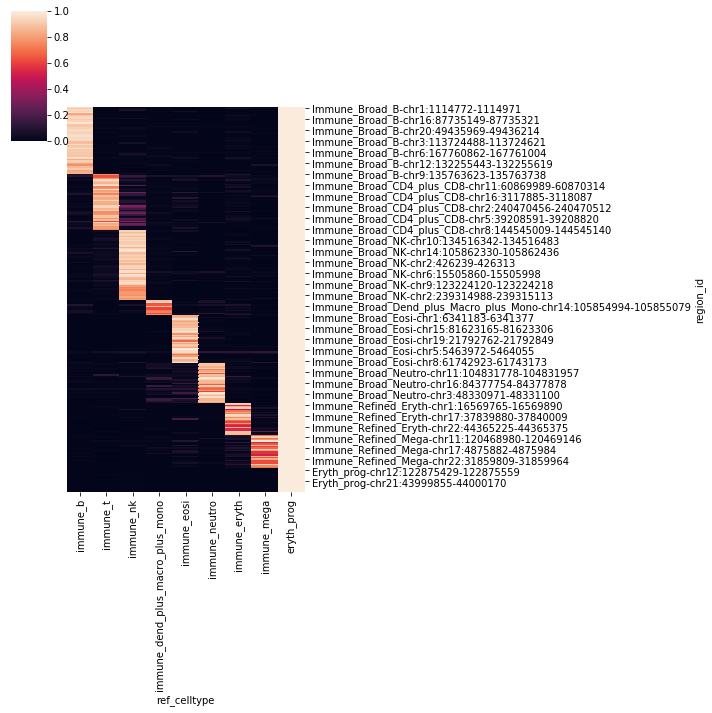

In [250]:
import seaborn as sns
sns.clustermap(atlas, row_cluster=False, col_cluster=False)

In [225]:
import cvxpy as cp
import numpy as np

# Generate some mock data for demonstration purposes
np.random.seed(0)
m, n = 100, 20  # m samples, n features
A = np.random.randn(m, n)
x_true = np.random.randn(n)
noise = np.random.randn(m)
b = A @ x_true + noise

# Variable to optimize
x = cp.Variable(n)

# Huber loss with threshold delta
delta = 1.0
residual = A @ x - b
huber_loss = cp.sum(cp.huber(residual, delta))

# Objective
objective = cp.Minimize(huber_loss)

# Nonnegativity constraints
# constraints = [x >= 0]

# Problem
prob = cp.Problem(objective)

# Solve
prob.solve()

print("Optimal value:", prob.value)
print("Optimal x:", x.value)

Optimal value: 76.30713253583609
Optimal x: [-1.64039103 -1.55628622  0.14849272 -0.86008183 -0.0410916  -0.73726563
 -0.77298445 -0.41831525  0.86579437  0.81893715  0.11954592 -1.03685154
  0.70797542  0.6713746   0.21076797 -0.54418703  0.8311723   0.61359754
 -3.31143925  0.73754109]


In [199]:
from scipy.optimize import nnls

def compute_deconvolution_nnls(score_df_path, score_type, atlas, match=True):
    '''
    Run nonnegative least squares ||Ax-b||_2. 
    The solution x is the deconvolution of b.
    
    Reasoning for match=True:
    Note that for lower total read count for a mixture, there be regions that
    are missing in score_df. At 1M reads, this not a problem.
    
    score_df -- methylation score dataframe
    score_type -- hypo or hyper score: e.g. 'frac_alpha_leq_25pct'
    atlas -- atlas dataframe
    '''
    # load score df
    score_df = pd.read_csv(score_df_path, sep='\t')
    score_df.index = score_df.region_id
    
    # subset score_df regions to atlas regions
    score_df = score_df[score_df.region_id.isin(atlas.index)]
    
    b = score_df[score_type]
    A = atlas
    
    # match index between A and b
    if match:
        region_count_before = A.shape[0]
        A = A[A.index.isin(b.index)]
        region_count_after = A.shape[0]
        region_count_diff = region_count_before - region_count_after 
        print(f'Dropped: {region_count_diff} regions.')
    
    # sort the indices for A to match b indices
    A_sorted = A.loc[b.index, :]
    
    # run NNLS
    fit = nnls(A_sorted, b)
    x = pd.Series(fit[0], index=A_sorted.columns)
    
    return(x)




def compute_deconvolution_ls(score_df_path, score_type, atlas, match=True):
    '''
    Run nonnegative least squares ||Ax-b||_2. 
    The solution x is the deconvolution of b.
    
    Reasoning for match=True:
    Note that for lower total read count for a mixture, there be regions that
    are missing in score_df. At 1M reads, this not a problem.
    
    score_df -- methylation score dataframe
    score_type -- hypo or hyper score: e.g. 'frac_alpha_leq_25pct'
    atlas -- atlas dataframe
    '''
    def ls(A, b):
        
        n = A.shape[1]
        x = cp.Variable(n)

        loss = A @ x - b
        ls_loss = cp.sum(loss ** 2)

        # Objective
        objective = cp.Minimize(ls_loss)

        # Problem
        prob = cp.Problem(objective)

        # Solve
        prob.solve()

        return(x.value)
    
    # load score df
    score_df = pd.read_csv(score_df_path, sep='\t')
    score_df.index = score_df.region_id
    
    # subset score_df regions to atlas regions
    score_df = score_df[score_df.region_id.isin(atlas.index)]
    
    b = score_df[score_type]
    A = atlas
    
    # match index between A and b
    if match:
        region_count_before = A.shape[0]
        A = A[A.index.isin(b.index)]
        region_count_after = A.shape[0]
        region_count_diff = region_count_before - region_count_after 
        print(f'Dropped: {region_count_diff} regions.')
    
    # sort the indices for A to match b indices
    A_sorted = A.loc[b.index, :]
    
    # run huber
    x = ls(A_sorted.to_numpy(), b)
    x = pd.Series(x, index=A_sorted.columns)

    
    return(x)

In [12]:
compute_deconvolution_nnls(score_df_path=score_df_path, score_type=score_type, atlas=atlas, match=True)

Dropped: 0 regions.


ref_celltype
immune_b                            0.060891
immune_t                            0.219701
immune_nk                           0.044624
immune_dend_plus_macro_plus_mono    0.099951
immune_eosi                         0.000549
immune_neutro                       0.562785
immune_eryth                        0.000000
immune_mega                         0.001687
eryth_prog                          0.000000
dtype: float64

In [13]:
import cvxpy as cp
import numpy as np

# Generate some mock data for demonstration purposes
np.random.seed(0)
m, n = 100, 20  # m samples, n features
A = np.random.randn(m, n)
x_true = np.random.randn(n)
noise = np.random.randn(m)
b = A @ x_true + noise

# Variable to optimize
x = cp.Variable(n)

# Huber loss with threshold delta
delta = 1.0
residual = A @ x - b
huber_loss = cp.sum(cp.huber(residual, delta))

# Objective
objective = cp.Minimize(huber_loss)

# Nonnegativity constraints
constraints = [x >= 0]

# Problem
prob = cp.Problem(objective, constraints)

# Solve
prob.solve()

print("Optimal value:", prob.value)
print("Optimal x:", x.value)

Optimal value: 609.0723266517177
Optimal x: [ 4.00737370e-20  2.13780616e-20  4.68978960e-01  2.01450982e-20
  7.31787074e-21  1.35573922e-20  5.78988648e-21  6.84941633e-01
  1.00810351e+00  1.21062061e+00  6.83818998e-01  2.15311255e-20
  1.16319259e+00  1.91580568e-20  2.82240607e-20  1.35544749e-20
  1.30003699e+00  2.78413809e-01 -3.45950675e-20  1.93977917e-20]


In [190]:
atlas.shape
    

(280, 9)

In [41]:
def compute_deconvolution_nnhuber(score_df_path, score_type, atlas, epsilon, match=True):
    '''
    Run nonnegative least squares ||Ax-b||_2. 
    The solution x is the deconvolution of b.
    
    Reasoning for match=True:
    Note that for lower total read count for a mixture, there be regions that
    are missing in score_df. At 1M reads, this not a problem.
    
    score_df -- methylation score dataframe
    score_type -- hypo or hyper score: e.g. 'frac_alpha_leq_25pct'
    atlas -- atlas dataframe
    '''
    def nnHuber(A, b, delta):
        
        n = A.shape[1]
        x = cp.Variable(n)

        loss = A @ x - b
        huber_loss = cp.sum(cp.huber(loss, delta))

        # Objective
        objective = cp.Minimize(huber_loss)

        # Nonnegativity constraints
        constraints = [x >= 0]

        # Problem
        prob = cp.Problem(objective, constraints)

        # Solve
        prob.solve()

        return(x.value)
    
    
    # load score df
    score_df = pd.read_csv(score_df_path, sep='\t')
    score_df.index = score_df.region_id
    
    # subset score_df regions to atlas regions
    score_df = score_df[score_df.region_id.isin(atlas.index)]
    
    b = score_df[score_type]
    A = atlas
    
    # match index between A and b
    if match:
        region_count_before = A.shape[0]
        A = A[A.index.isin(b.index)]
        region_count_after = A.shape[0]
        region_count_diff = region_count_before - region_count_after 
        print(f'Dropped: {region_count_diff} regions.')
    
    # sort the indices for A to match b indices
    A_sorted = A.loc[b.index, :]
    
    # run huber
    x = nnHuber(A_sorted.to_numpy(), b, delta=epsilon)
    x = pd.Series(x, index=A_sorted.columns)
    
    # extremely small, less than -10^10, just round to 0
    threshold = 10 ** -10
    abs(x) < threshold
    x[abs(x) < threshold] = 0
    
    return(x)


def compute_deconvolution_n_times_nnhuber(mixture_replicates_path, score_type, atlas, epsilon, match=True):
    '''
    
    mixture_replicates_path -- path to a mixture (proportion) directory of replicates (e.g. ../E1B_E18CD4_E18CD8_E18NK_E18MONO_E18NEUTRO/)
    output: pandas df
    
    '''
    # given path to mixture grab all paths to mixture replicates
    list_mixture_dir_paths = get_file_paths(mixture_replicates_path)
    
    # run deconvolution for each replicate
    results = []
    samples_name = []
    for path in list_mixture_dir_paths:
        deconv = compute_deconvolution_nnhuber(score_df_path=path, 
                                           atlas=atlas, 
                                           score_type=score_type, 
                                           match=match)
        results.append(deconv)
    df = pd.concat(results, axis=1)
    
    return df 


def compute_deconvolution_from_methyl_score_dir_nnhuber(path_to_methyl_score_dir, score_type, atlas, epsilon, match=True):
    '''
    '''
    # grab all file paths in methyl_score directory
    list_methyl_score_dir = get_file_paths(path_to_methyl_score_dir)
    
    # run deconvolution on each mixture proportion
    results = []
    for path in list_methyl_score_dir:
        df = compute_deconvolution_n_times_nnhuber(mixture_replicates_path=path, 
                                               score_type=score_type, 
                                               atlas=atlas, 
                                               epsilon=epsilon,
                                               match=match)
        results.append(df)
    
    return(results)



In [42]:
score_df_path = '/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/output/experiment/primary_immune/Blueprint-B-wholeblood/methyl_score/E06B_E16CD4_E07CD8_E05NK_E09MONO_E57NEUTRO/mix10_seed928973.tsv.gz'
score_type = 'frac_alpha_leq_25pct'
epsilon = 1

pred_nnhuber = compute_deconvolution_nnhuber(score_df_path=score_df_path, score_type=score_type, atlas=atlas, epsilon=epsilon, match=True)
pred_nnhuber

Dropped: 0 regions.


ref_celltype
immune_b                            0.060891
immune_t                            0.219701
immune_nk                           0.044624
immune_dend_plus_macro_plus_mono    0.099951
immune_eosi                         0.000549
immune_neutro                       0.562785
immune_eryth                        0.000000
immune_mega                         0.001687
eryth_prog                          0.000000
dtype: float64

In [197]:
# def nnHuber(A, b, delta):
    
#     n_celltype = A.shape[1]
#     x = cp.Variable(n_celltype)

#     loss = A @ x - b
#     huber_loss = cp.sum(cp.huber(loss, delta))

#     # Objective
#     objective = cp.Minimize(huber_loss)

#     # Nonnegativity constraints
#   #  constraints = [x >= 0]

#     # Problem
#     prob = cp.Problem(objective) #, constraints)

#     # Solve
#     prob.solve()

#     return(x.value)

# def leastsquares(A, b):
    
#     n_celltype = A.shape[1]
#     x = cp.Variable(n_celltype)

#     loss = A @ x - b
#     ls_loss = cp.sum(loss ** 2)

#     # Objective
#     objective = cp.Minimize(ls_loss)

#     # Nonnegativity constraints
#    # constraints = [x >= 0]

#     # Problem
#     prob = cp.Problem(objective) # constraints)

#     # Solve
#     prob.solve()

#     return(x.value)

# score_df_path = '/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/output/experiment/primary_immune/Blueprint-B-wholeblood/methyl_score/E06B_E16CD4_E07CD8_E05NK_E09MONO_E57NEUTRO/mix10_seed928973.tsv.gz'
# score_type = 'frac_alpha_leq_25pct'

# score_df = pd.read_csv(score_df_path, sep='\t')
# score_df.index = score_df.region_id

# # subset score_df regions to atlas regions
# score_df = score_df[score_df.region_id.isin(atlas.index)]



# b = score_df[score_type]
# A = atlas.to_numpy()

# nnHuber(A=A, b=b, delta=1)

In [135]:
A = np.array([[1, 1, 0, 0, 0], 
              [1, 1, 0, 0, 0],
              [1, 1, 1, 0, 0],
              [1, 1, 1, 1, 0], 
              [0, 1, 1, 0, 1]])

x_true = np.array([[0.3], [0], [0.3], [0.2], [0.2]])

b = A.dot(x_true)#  + np.array([[0.3], [0.6], [0.02], [0.2], [0.1]])

In [136]:
b

array([[0.3],
       [0.3],
       [0.6],
       [0.8],
       [0.5]])

In [137]:
x1 = cp.Variable((5, 1))
objective1 = cp.Minimize(cp.norm(A @ x1 - b, "fro"))
problem1 = cp.Problem(objective1)
problem1.solve()
x1_val = x1.value
x1_val_fixed = np.copy(x1_val)
x1_val_fixed[x1_val_fixed < 0] = 0

# Scenario 2: With non-negativity constraints
x2 = cp.Variable((5, 1), nonneg=True)
objective2 = cp.Minimize(cp.norm(A @ x2 - b, "fro"))
problem2 = cp.Problem(objective2)
problem2.solve()
x2_val = x2.value

print("True x:", x_true)
# print("Estimated x (Scenario 1):", x1_val)
print("Fixed x (Scenario 1):", x1_val_fixed)
print("Estimated x (Scenario 2):", x2_val)

True x: [[0.3]
 [0. ]
 [0.3]
 [0.2]
 [0.2]]
Fixed x (Scenario 1): [[0.13333333]
 [0.16666667]
 [0.3       ]
 [0.2       ]
 [0.03333333]]
Estimated x (Scenario 2): [[0.23316032]
 [0.06683968]
 [0.3       ]
 [0.2       ]
 [0.13316032]]


In [138]:
sum((x_true - x1_val_fixed) ** 2) / len(x_true)

array([0.01666667])

In [139]:
sum((x_true - x2_val) ** 2) / len(x_true)

array([0.00268053])

In [140]:
x1_val

array([[0.13333333],
       [0.16666667],
       [0.3       ],
       [0.2       ],
       [0.03333333]])

In [165]:
import cvxpy as cp
import numpy as np

np.random.seed(42)

# Create a matrix A where columns are nearly collinear
A = np.array([[1, 1 + 1e-5], 
              [2, 2 - 1e-5]])

# Set a true x which doesn't have any negative values
x_true = np.array([[2], [1]])

# Generate b using the true x and add some noise
b = A.dot(x_true) + np.array([[0.1], [0.1]])


# Scenario 1: Without non-negativity constraints
x1 = cp.Variable((2, 1))
objective1 = cp.Minimize(cp.norm(A @ x1 - b, "fro"))
problem1 = cp.Problem(objective1)
problem1.solve()
x1_val = x1.value

x1_val_fixed = np.copy(x1_val)
x1_val_fixed[x1_val_fixed < 0] = 0


# Scenario 2: With non-negativity constraints
x2 = cp.Variable((2, 1), nonneg=True)
objective2 = cp.Minimize(cp.norm(A @ x2 - b, "fro"))
problem2 = cp.Problem(objective2)
problem2.solve()
x2_val = x2.value

print("True x:", x_true)
print("Estimated x (Scenario 1):", x1_val)
print("Estimated x (Scenario 2):", x2_val)

True x: [[2]
 [1]]
Estimated x (Scenario 1): [[-3331.26233305]
 [ 3334.32899971]]
Estimated x (Scenario 2): [[8.01678920e-06]
 [3.05999598e+00]]


In [166]:
A

array([[1.     , 1.00001],
       [2.     , 1.99999]])

In [167]:
x_true

array([[2],
       [1]])

In [168]:
b

array([[3.10001],
       [6.09999]])

In [174]:
x1_val

array([[-3331.26233305],
       [ 3334.32899971]])

In [172]:
sum((x_true - x1_val_fixed) ** 2) / len(x_true)

array([5555543.11016071])

In [170]:
sum((x_true - x2_val) ** 2) / len(x_true)

array([4.12177568])

In [360]:
import cvxpy as cp


def nnHuber(A:'numpy.ndarray', b:'numpy.ndarray', delta=1, nonnegative=False)->'numpy.ndarray':
    '''
    Huber regression with the option to include nonnegativity constraint, 
    i.e. return a nonnegative solution. 
    
    Note: 
    - Make sure the order of the rows of A and b match
    - Intercept is not included in the solution. To fit the model with intercept
      concatenate a column of ones to the matrix A. 
    - In conventional supervised learning notation:
        - A: X
        - b: y
        - x: beta
    
    Arguments: 
    A -- numpy array of shape (n, k)
    b -- numpy array of shape (n,  )
    delta -- determines huber where least squares and absolute value loss meet
    nonnegative -- boolean for including nonnegativtiy constraint (x >= 0): 
    '''
    n = A.shape[1]
    
    if nonnegative:
        x = cp.Variable(n, nonneg=True)
    else: 
        x = cp.Variable(n)
    
    # loss
    loss = A @ x - b
    huber_loss = cp.sum(cp.huber(loss, delta))
    
    # objective
    objective = cp.Minimize(huber_loss)
    
    # solve
    prob = cp.Problem(objective)
    prob.solve()

    return(x.value)


if __name__ == "__main__":
    
    # Toy example
    A = np.array([[1, 0, 0, 1, 1], 
                  [0, 1, 0, 1, 1],
                  [0, 0, 1, 1, 1],
                  [0, 0, 0, 1, 1], 
                  [0, 0, 0, 1, 1]])

    x = np.array([0.2, 0, 0, 0.4, 0.4])
    b = A.dot(x) + np.array([0.05, 0.01, 0.02, 0.02, 0.07])
    
    print('ground truth x: ', x)

    # solve for x using huber
    xhat = nnHuber(A, b, delta=5, nonnegative=False)
    print('solution (w/o constraint): ', x_hat)
 
    # solve for x using huber w/ nonnegativity constraint
    xhat_nn = nnHuber(A, b, delta=5, nonnegative=True)
    print('solution (w/ constraint): ', np.round(xhat_nn, 3))

ground truth x:  [0.2 0.  0.  0.4 0.4]
solution (w/o constraint):  [ 0.205  -0.035  -0.025   0.4225  0.4225]
solution (w/ constraint):  [0.22  0.    0.    0.415 0.415]


In [361]:
import cvxpy as cp


def nnHuber(A:'numpy.ndarray', b:'numpy.ndarray', delta=1, nonnegative=False)->'numpy.ndarray':
    '''
    Huber regression with the option to include nonnegativity constraint, 
    i.e. return a nonnegative solution. 
    
    Note: 
    - Make sure the order of the rows of A and b match
    - Intercept is not included in the solution. To fit the model with intercept
      concatenate a column of ones to the matrix A. 
    - In conventional supervised learning notation:
        - A: X
        - b: y
        - x: beta
    
    Arguments: 
    A -- numpy array of shape (n, k)
    b -- numpy array of shape (n,  )
    delta -- determines huber where least squares and absolute value loss meet
    nonnegative -- boolean for including nonnegativtiy constraint (x >= 0): 
    '''
    n = A.shape[1]
    
    if nonnegative:
        x = cp.Variable(n, nonneg=True)
    else: 
        x = cp.Variable(n)
    
    # loss
    loss = A @ x - b
    huber_loss = cp.sum(cp.huber(loss, delta))
    
    # objective
    objective = cp.Minimize(huber_loss)
    
    # solve
    prob = cp.Problem(objective)
    prob.solve()

    return(x.value)


if __name__ == "__main__":
    
    # Toy example
    A = np.array([[1, 0, 0, 1, 1], 
                  [0, 1, 0, 1, 1],
                  [0, 0, 1, 1, 1],
                  [0, 0, 0, 1, 1], 
                  [0, 0, 0, 1, 1]])

    x = np.array([0.2, 0, 0, 0.4, 0.4])
    b = A.dot(x) + np.array([0.05, 0.01, 0.02, 0.02, 0.07])
    
    print('ground truth x: ', x)

    # solve for x using huber
    xhat = nnHuber(A, b, delta=5, nonnegative=False)
    print('solution (w/o constraint): ', x_hat)
 
    # solve for x using huber w/ nonnegativity constraint
    xhat_nn = nnHuber(A, b, delta=5, nonnegative=True)
    print('solution (w/ constraint): ', np.round(xhat_nn, 3))

ground truth x:  [0.2 0.  0.  0.4 0.4]
solution (w/o constraint):  [ 0.205  -0.035  -0.025   0.4225  0.4225]
solution (w/ constraint):  [0.22  0.    0.    0.415 0.415]
